# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения 
    * SGD+momentum, Adam
    
Адрес для посылки ДЗ mfti_2018_hw03@mail.ru

# Требуемые модули:
Python 3.6
1. pytorch=0.41 // [инструкция по установке](https://pytorch.org/get-started/previous-versions/)
2. torchvision=0.2.2.post3 // pip install ...
3. matplotlib  //
4. PIL=5.4.1
5. scipy=1.1.0
6. numpy=1.15.14
7. pickle

# Требования
1. Присылаем этот ноутбук только с полностью выполненными заданиями.
2. Файл должен называть MFTI_2019_hw03_ФАМИЛИЯ_ИМЯ.ipynb
3. Заданние должно быть выполнено до 24.03.2019 до 23:59.
4. После проверки у Вас будет одна попытка для исправления замечаний. 

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку <font collor='red'>__pytorch__</font>. Получаем на вход тензор размером $(C_{in}, H, W)$, на выходе получаем тензор $(C_{out}, H_{out}, W_{out})$.
$$
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки с параметрами:

$\large k $ - ядро свертки, тензор с парамерами $C_{in}, H_k, W_k,$ <br>
$stride_{H,W}$ - шаг ядра свертки, <br>
$padding_{H,W} $ - размер паддинга.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [1]:
import copy
# прототип функции 
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда, задаются в формате HxW
    :param  padding:  tuple - параметры паддинга, задаются в формате HxW
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    # 1. Проверка размерности 
    #    Если не 4Д, то добавляем размерности
    x = copy.deepcopy(x)
    x_shape = x.shape
    if (len(x_shape) == 3):
        x = torch.unsqueeze(x, 0)
    
    #2. Получени вссех нужных размеров и инницыализация тензоров
    
    B, C, H, W = x.shape
    C_ker, H_ker, W_ker = kernel.shape
    C_out = 1
    H_out = int((H + 2*padding[0] - H_ker) / stride[0] + 1)
    W_out = int((W + 2*padding[1] - W_ker) / stride[1] + 1)
    
    out = torch.FloatTensor(B, 1, H_out, W_out).fill_(0)
    
    # 3. Добаляем паддинг, если нужно
    
    if(padding[0] != 0 or padding[1] != 0):
        pad = (padding[1], padding[1], padding[0], padding[0])
        x = torch.nn.functional.pad(x, pad, mode='constant', value=0)
    
    # 4. Непосредственно проход сверткой
    
    for b in range(B):
        cur_img = x[b]
        for h in range(H_out):
            for w in range(W_out):
                cur_piece = cur_img[:, h*stride[0]:h*stride[0] + H_ker, 
                                    w*stride[1]:w*stride[1] + W_ker]
                out[b, :, h, w] = torch.sum(cur_piece * kernel)
    if(bias != None):
        out += bias
        
    out = torch.squeeze(out, 0)
    out = torch.squeeze(out, 0)
    return out


#from my_conv2d import my_conv2d

In [2]:
# функции тестирования
from tests_functions import * 

### Загружаем картинку 

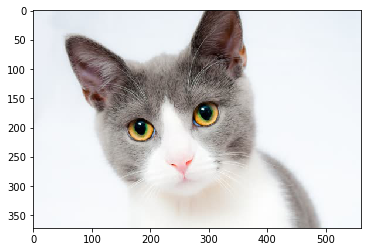

In [3]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [4]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [5]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([370, 558])


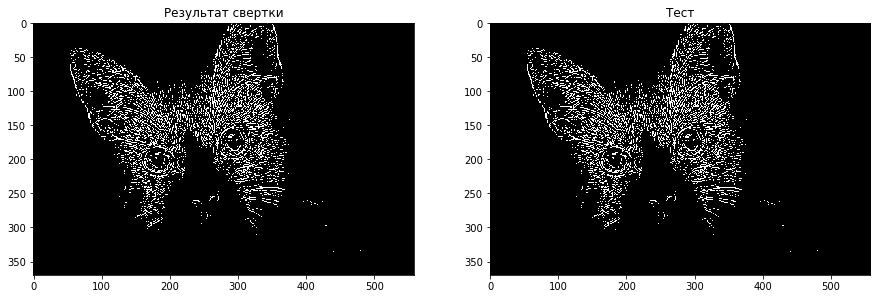

In [6]:

o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_01.pth')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [7]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


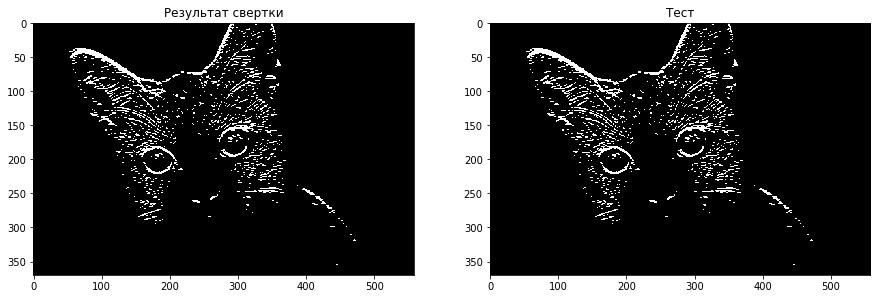

In [8]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_02.pth')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [9]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


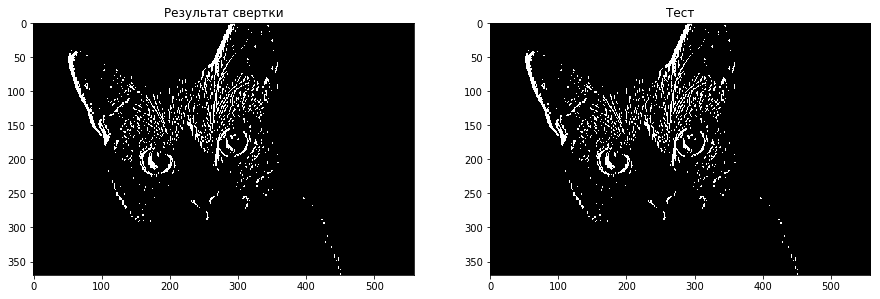

In [10]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_03.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])
torch.Size([186, 280])


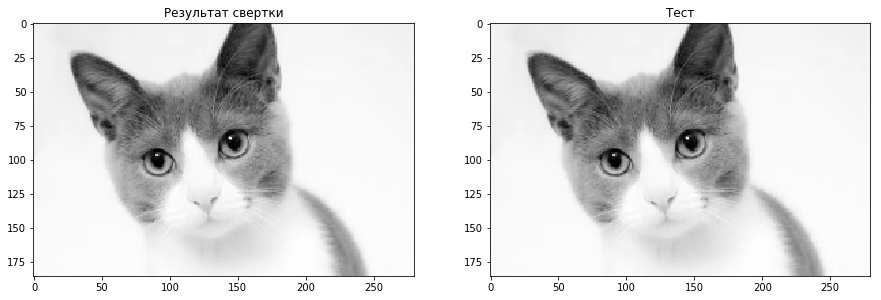

In [11]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
#torch.save(o_image, './data/kernel_05.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_05.pth')
assert o_image.size() == torch.Size([186, 280]), 'Размер выходного изображения не совпадает с размером теста'
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 1, padding 1

torch.Size([372, 560])


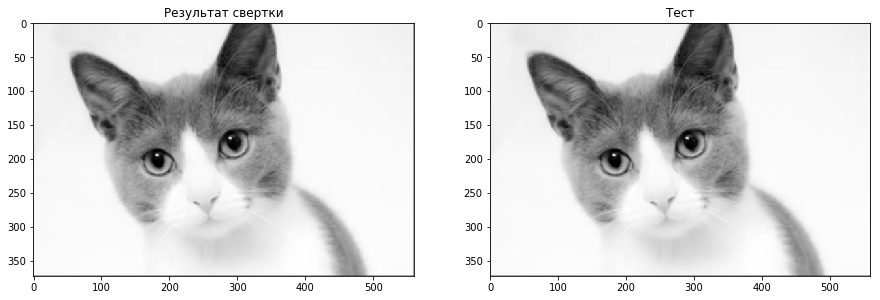

In [12]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(1,1), padding=(1,1))
o_image /= 4 # усредняем
#torch.save(o_image, './data/kernel_04.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_04.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 2, padding 2

torch.Size([187, 281])


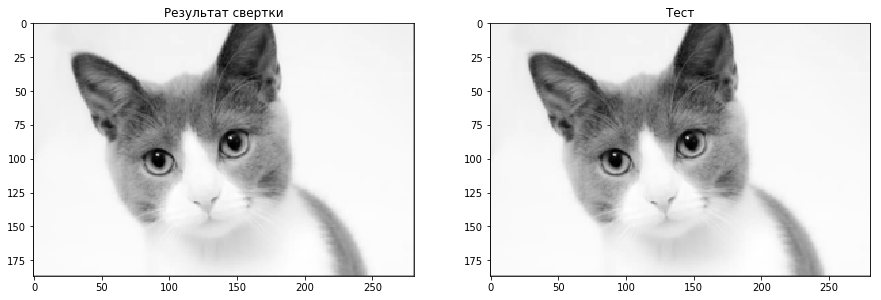

In [13]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2), padding=(2,2))
o_image /= 4 # усредняем
test_conv(o_image, './data/kernel_06.pth')

### Ядро свертки с гаусовым распределением

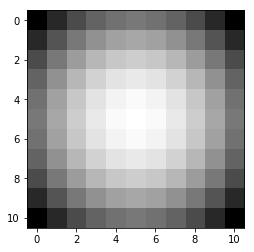

In [14]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([362, 550])


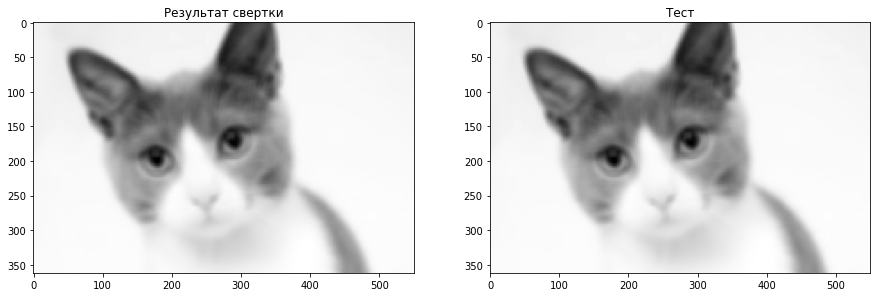

In [15]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
test_conv(o_image, './data/kernel_07.pth', False)

# Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - \mu}{ \sqrt{\sigma^2 + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя \ в \ режиме\ тренировки
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \\ параметры считаются в процессе тренировки
\gamma, b $ - обучаемые параметры параметры.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй (компонентом векторов)

Нужные функции
```python
import torch
torch.zeros - создать тензор заполненный нулями
torch.ones - создать тензор заполненный единицами
torch.Tensor - создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  - среднее и дисперсия
x.uniform_ - заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) - разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1
x.unsqueeze(dim) - добавить размерность в тензор
x.squeeze - убрать размерность

```

### <font color=red>Важно</font> 
Код батч нормализации должен быть максимально простым, _циклы_ в нем не нужны. Используйте встроенные функции torch view, mean, var, unsqueeze, expand_as

In [140]:
import torch.nn as nn

import torch.nn as nn

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
         Инициализация BN
         Если задан флаг afine, то должны быть проинициализированны матрицы гамма и b
         для осуществления афинных преобразований в процессе тренировки и теста.
         Обучаемый параметры устанавливаем как тензора соответсвующей размерности и сохраняем 
         их 
         self.weight
         self.bias
         В данном ДЗ мы не обучаем эти параметры, лишь реализуем саму концепцию.
         
         !!! чтобы проходил последний тест на картинках мниста нужно инициализировть beta & epsilon из аргументов
         
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование в процессе обучения.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()
        self.beta = beta
        self.epsilon = epsilon
        if(afine == True):
            self.weight = torch.ones(in_channels, 1, 1).uniform_()
            self.bias = torch.zeros(in_channels, 1, 1)
        self.afine = afine
        self.training = True
        self.runing_var = torch.zeros(in_channels, 1, 1)
        self.runing_mean = torch.zeros(in_channels, 1, 1)
            
        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        используем для расчета праметры gamma и b КАК обучаемые, т.е. учитываем, 
        что эти параметры должны быть обучены в процессе тренировки. 
        """
        x = copy.deepcopy(x)
        if self.training:
            if(len(x.shape) == 4):
                N, C, H, W = x.shape
            else:
                C, H, W = x.shape
            x_mu = x.transpose(1, 0)
            x_mu = torch.reshape(x_mu, (C, -1))
            mu = torch.mean(x_mu, 1)
            mu = torch.reshape(mu, (C, 1, 1))
            x_var = x.transpose(1, 0)
            x_var = torch.reshape(x, (C, -1))
            var = torch.var(x_var, 1)
            var = torch.reshape(var, (C, 1, 1))
            self.runing_mean = self.beta * self.runing_mean + (1 - self.beta) * mu
            self.runing_var = self.beta * self.runing_var + (1 - self.beta) * var
            out = (x - mu) / torch.sqrt(var + self.epsilon) 
        else:
            out = (x - self.runing_mean) / torch.sqrt(self.runing_var + self.epsilon) 
            
        if(self.afine == True):
            out = out * self.weight + self.bias
        return out

### Проверяем работу батч нормадлизации на котэ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([372, 560, 3])


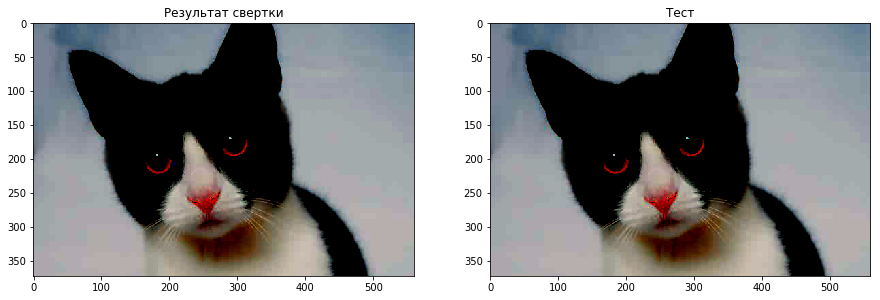

In [141]:
from tests_functions import test_conv 
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
assert bn.runing_mean.size()[0] == 3 and bn.runing_var.size()[0] == 3,  "Размерности  runing_mean & runing_var должны совпадать с количеством входных каналов"
assert bn.runing_mean[0] != bn.runing_mean[1],  "Странно, что у вас совпадают значения средних по каналам"
test_conv(o_image, './data/bn_01.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([372, 560, 3])


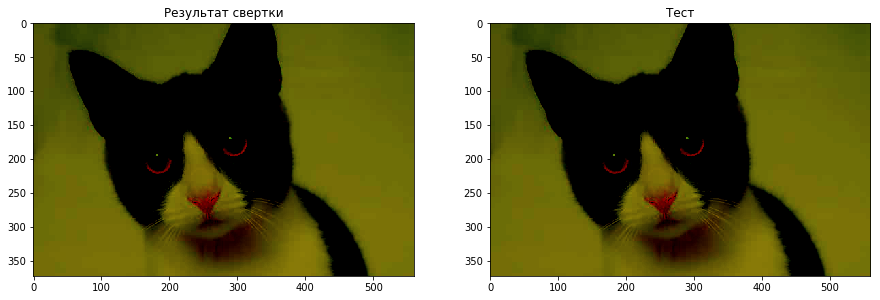

In [142]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
# Поэтому, чтобы получить детерменированный результат устанавливаем seed
# !!! Если Вы делаете перезапуск последующих тестов по BN, то их нужно делать с этого места, 
# иначе тесты могут не проходить.
torch.manual_seed(999)

bn = BatchNorm2d(3, afine=True)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_02.pth')
#print (o_image.size())

### Проверим как реализация работает на большом сете картинок
Цель проверить расчет running_mean and running_var, эти переменные мы расчитываем в режиме тренировки

In [13]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [14]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


/nmnt/media/home/farshov/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/nmnt/media/home/farshov/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


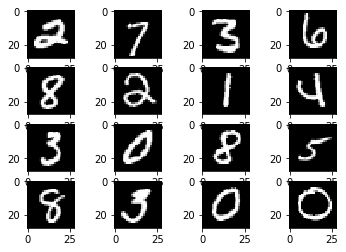

In [15]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются скользящее среднее значение в процессе тренировки

In [16]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    np.random.seed(999)
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ bn.runing_mean ] 
            var_curve +=  [ bn.runing_var ]
    return mean_curve, var_curve

In [147]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

BN beta=09


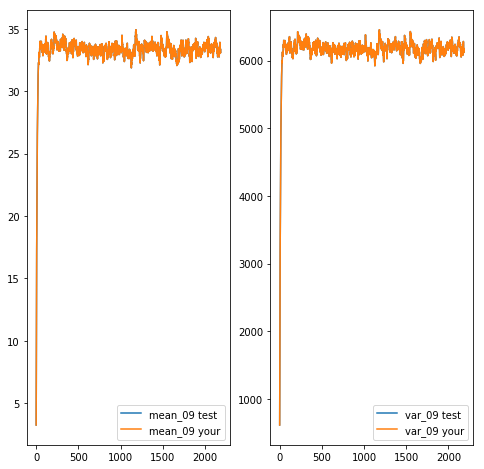

In [148]:
print ("BN beta=09")
test_bn_plots(mean_curve_09, var_curve_09, '09')

BN beta=099


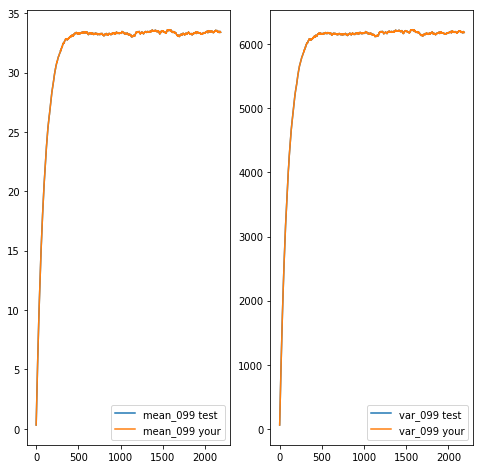

In [149]:
print ("BN beta=099")
test_bn_plots(mean_curve_099, var_curve_099, '099')

BN beta=05


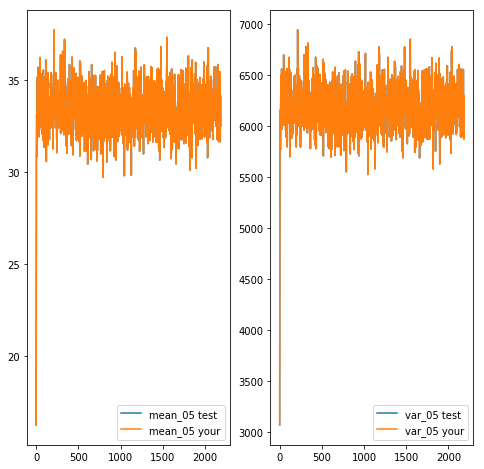

In [150]:
print ("BN beta=05")
test_bn_plots(mean_curve_05, var_curve_05, '05')

Смотрим какие значения средних и дисперсий у нас получились

In [151]:
print ("Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed")
assert int(bn_09.runing_mean[0]) == 33
assert int(bn_099.runing_mean[0]) == 33
assert int(bn_05.runing_mean[0]) == 32
assert int(bn_09.runing_var[0]) == 6136
assert int(bn_099.runing_var[0]) == 6180
assert int(bn_05.runing_var[0]) == 6038
print ('ok')

Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed
ok


Посмотрим как повлияла батч нормализация на изображения

In [152]:
bn_09.weight

tensor([[[0.9424]]])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


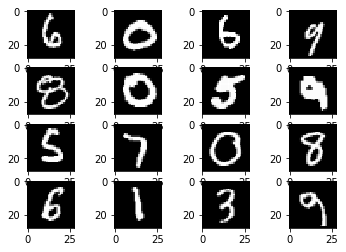

In [153]:
n=4
bn = bn_09
bn.train(False) # эмулируем режим тестирования
np.random.seed(666)
for i in range(n*n):
    print(i)
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0)).squeeze(0).squeeze()
    # загрузим сохраненный тестовый тензор 
    t_I = torch.load('./data/bn_minst_%2d.pth'%i)
    # проверим, что нормализованный и тестовый тензор совпадают 
    assert (I == t_I).all(), "Что-то не так нормализованный тензор и тестовый не совпадают"
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), построить графики для различных параметров для каждого алгоритма, сделать выводы о скорости сходимости


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \ m_{t-1} + (1 - \alpha)\ g - момент \\ 
v_t &= \beta \ v_{t-1} +  (1-\beta)\ g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^{\frac{1}{2}}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$


In [3]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)
        

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] 
            eps = group['eps']
            lr = group['lr']
            step_size = lr * math.sqrt(1 - beta2) / (1 - beta1)
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                # забираем тензор градиента    
                grad = p.grad.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # скользящее среднее по квадрату градиентов
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                        
                # запоминаем шаг
                state['step'] += 1 

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                exp_avg = exp_avg * beta1 + (1 - beta1) * grad
                exp_avg_sq = exp_avg_sq * beta2 + (1 - beta2) * grad**2

                # обновляем веса в p.data, 
                p.data = p.data - step_size * exp_avg.mul_(1 / torch.sqrt(exp_avg_sq + eps))
                
        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta m_{t-1} - (1- \beta) g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha m_{t-1} - \lambda g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [4]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad.data
                
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['momentum'] = torch.zeros_like(p.data)
                    
                momentum = state['momentum']
                
                # Если бэта не ноль, то получаем сгд с моментумом, если ноль, то просто градиент
                momentum = momentum * beta + (1 - beta) * grad
                
                state['step'] += 1 

                p.data = p.data - lr * momentum


        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [17]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [18]:
USE_CUDA=True

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        # добавляем бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))            
        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        # добавляем бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            
        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))
        # Линейный слой классификатора
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        return x

## Функция обучения модели

In [6]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss[0] )
            loss.backward()
            optimizer.step()  
        avg_epoch_loss = loss_acc / (nbatches)
        #print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [221]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
loss_curve_sgd_1 = fit_net(20, net, optimizer)

/nmnt/media/home/farshov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.11987878252408468
Do epoch 1 with loss 0.05173266083206496
Do epoch 2 with loss 0.04213351585655709
Do epoch 3 with loss 0.0359389235235318
Do epoch 4 with loss 0.031274758838031956
Do epoch 5 with loss 0.028245777096113877
Do epoch 6 with loss 0.025413691087923587
Do epoch 7 with loss 0.023646715743987592
Do epoch 8 with loss 0.021374707267362885
Do epoch 9 with loss 0.019614961286167822
Do epoch 10 with loss 0.017875983500295324
Do epoch 11 with loss 0.017159511710363378
Do epoch 12 with loss 0.01591654701706041
Do epoch 13 with loss 0.014680807577947748
Do epoch 14 with loss 0.014472267322606784
Do epoch 15 with loss 0.012483822765228244
Do epoch 16 with loss 0.0115437688937076
Do epoch 17 with loss 0.012030952762102066
Do epoch 18 with loss 0.010522677363409646
Do epoch 19 with loss 0.009989856208738912


## SGD с моментом

In [213]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)

/nmnt/media/home/farshov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.3230054440955403
Do epoch 1 with loss 0.10382563555736656
Do epoch 2 with loss 0.07697212032438905
Do epoch 3 with loss 0.0640544619940981
Do epoch 4 with loss 0.05582448873186853
Do epoch 5 with loss 0.05033627006633673
Do epoch 6 with loss 0.04602427781650232
Do epoch 7 with loss 0.04260341038354249
Do epoch 8 with loss 0.040142766833237226
Do epoch 9 with loss 0.038105561569585174
Do epoch 10 with loss 0.03528473082338777
Do epoch 11 with loss 0.03354047698739134
Do epoch 12 with loss 0.03251097855853555
Do epoch 13 with loss 0.03048294987384729
Do epoch 14 with loss 0.0294965316116074
Do epoch 15 with loss 0.02850194753006707
Do epoch 16 with loss 0.02704773886554253
Do epoch 17 with loss 0.02643426263446834
Do epoch 18 with loss 0.02603836844759986
Do epoch 19 with loss 0.024622132445531835


## Adam

In [214]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

/nmnt/media/home/farshov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.21238123460076186
Do epoch 1 with loss 0.0701786765482091
Do epoch 2 with loss 0.05761257136963686
Do epoch 3 with loss 0.05151941855857511
Do epoch 4 with loss 0.046806762356926004
Do epoch 5 with loss 0.04335551802622547
Do epoch 6 with loss 0.04202875580807282
Do epoch 7 with loss 0.04042713915751195
Do epoch 8 with loss 0.0372142210691336
Do epoch 9 with loss 0.03536209648038134
Do epoch 10 with loss 0.03353366952101607
Do epoch 11 with loss 0.03392740641220225
Do epoch 12 with loss 0.03157384634344993
Do epoch 13 with loss 0.03088175154844266
Do epoch 14 with loss 0.030055340643500322
Do epoch 15 with loss 0.030042354407569943
Do epoch 16 with loss 0.02878436379417416
Do epoch 17 with loss 0.02840698283177617
Do epoch 18 with loss 0.026820586814583845
Do epoch 19 with loss 0.026934549151134097


# Кривые обучения

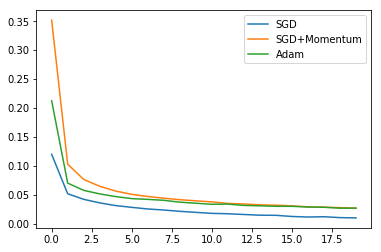

In [222]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd_1,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

# Выводы
Тут нужно написать выводы по сравнению скорости сходимлости алгоритмов SGD, SGD + Momentum, ADAM для различных праметров
1. lr - коэффициент обучения для всех элгоритмов (0.1, 0.01, 0.001, 0.0001) при фиксированных остальных гиперпараметрах 
2. beta - для SGD + momentum (0,9, 0,99, 0,5) для лучшего графика в пункте 1.
3. beta1, beta2 - для ADAM - для различных значений (0,9, 0,99, 0,5) для лучшего графика в пункте 1.

TODO

# Задание 1

## SGD без момента

In [223]:
lr = [0.1, 0.01, 0.001, 0.0001]

In [224]:
sgd_loss = []
for learning_rate in lr:
    net = Net(batchnorm=True)
    net = net.cuda() if USE_CUDA else net
    optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
    loss_curve_sgd = fit_net(20, net, optimizer)
    sgd_loss.append(loss_curve_sgd)

/nmnt/media/home/farshov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.12726952129260394
Do epoch 1 with loss 0.05889592073077637
Do epoch 2 with loss 0.04540387502218634
Do epoch 3 with loss 0.0376358090396962
Do epoch 4 with loss 0.03320834200759429
Do epoch 5 with loss 0.029650976447874844
Do epoch 6 with loss 0.02617706162884838
Do epoch 7 with loss 0.02299503593696652
Do epoch 8 with loss 0.02190785307929458
Do epoch 9 with loss 0.019287094392076605
Do epoch 10 with loss 0.017561211013526857
Do epoch 11 with loss 0.016064043016699715
Do epoch 12 with loss 0.014055255236667098
Do epoch 13 with loss 0.015019102941024886
Do epoch 14 with loss 0.012866308346261268
Do epoch 15 with loss 0.012091428283337976
Do epoch 16 with loss 0.011008467860809461
Do epoch 17 with loss 0.010219257037062921
Do epoch 18 with loss 0.009228831394709678
Do epoch 19 with loss 0.009087144664203843
Do epoch 0 with loss 0.2840119939030007
Do epoch 1 with loss 0.08638736405837846
Do epoch 2 with loss 0.06669726392410093
Do epoch 3 with loss 0.05704072053077

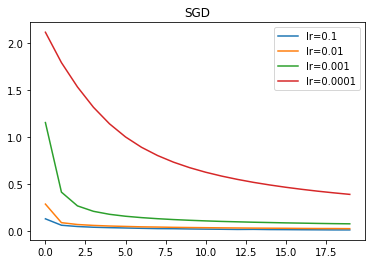

In [234]:
ax = plt.subplot(1,1,1)
ax.plot(sgd_loss[0],label="lr=0.1")
ax.plot(sgd_loss[1],label="lr=0.01")
ax.plot(sgd_loss[2],label="lr=0.001")
ax.plot(sgd_loss[3],label="lr=0.0001")
plt.title("SGD")
ax.legend()

### Вывод по SGD: лучше всего сходится при значении lr=0.1, наблюдается тенденция к увеличению скорости сходимости при увеличении learning rate

## SGD + mometum

In [225]:
mom_loss = []
for learning_rate in lr:
    net = Net(batchnorm=True)
    net = net.cuda() if USE_CUDA else net
    optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
    loss_curve_sgd_momentum = fit_net(20, net, optimizer)
    mom_loss.append(loss_curve_sgd_momentum)

/nmnt/media/home/farshov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.3346169308393471
Do epoch 1 with loss 0.10066407078482759
Do epoch 2 with loss 0.07582039132571188
Do epoch 3 with loss 0.06389719741116608
Do epoch 4 with loss 0.055610426569167586
Do epoch 5 with loss 0.05074854120850618
Do epoch 6 with loss 0.04625502075773426
Do epoch 7 with loss 0.042718773945368854
Do epoch 8 with loss 0.040113356715612454
Do epoch 9 with loss 0.037876776545204195
Do epoch 10 with loss 0.03620664227224127
Do epoch 11 with loss 0.03452927537115949
Do epoch 12 with loss 0.0332956727054166
Do epoch 13 with loss 0.031469041938971425
Do epoch 14 with loss 0.029939531360143497
Do epoch 15 with loss 0.029050037745176848
Do epoch 16 with loss 0.028233157086710325
Do epoch 17 with loss 0.027328735284735527
Do epoch 18 with loss 0.02572033934850479
Do epoch 19 with loss 0.02522408019259034
Do epoch 0 with loss 1.3052246190120382
Do epoch 1 with loss 0.5195620122651395
Do epoch 2 with loss 0.34903804882236633
Do epoch 3 with loss 0.2739947392827962
Do

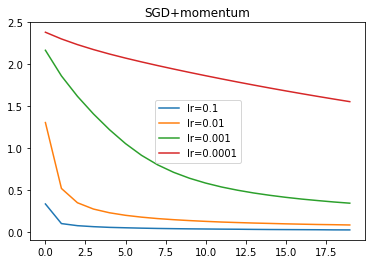

In [239]:
ax = plt.subplot(1,1,1)
ax.plot(mom_loss[0],label="lr=0.1")
ax.plot(mom_loss[1],label="lr=0.01")
ax.plot(mom_loss[2],label="lr=0.001")
ax.plot(mom_loss[3],label="lr=0.0001")
plt.title('SGD+momentum')
plt.legend()

### Вывод по SGD + momentum: лучше всего сходится при значении lr=0.1, наблюдается тенденция к увеличению скорости сходимости при увеличении learning rate

## Adam

In [227]:
adam_loss = []
for learning_rate in lr:
    net = Net(batchnorm=True)
    net = net.cuda() if USE_CUDA else net
    optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    loss_curve_adam = fit_net(20, net, optimizer)
    adam_loss.append(loss_curve_adam)

/nmnt/media/home/farshov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.35319233993191834
Do epoch 1 with loss 0.3060492928721995
Do epoch 2 with loss 0.3270525678167836
Do epoch 3 with loss 0.3392167780897527
Do epoch 4 with loss 0.45539669062266025
Do epoch 5 with loss 0.6770258771539225
Do epoch 6 with loss 0.7342155417610534
Do epoch 7 with loss 2.3087156550438372
Do epoch 8 with loss 2.3155775982111515
Do epoch 9 with loss 2.3109026784814
Do epoch 10 with loss 2.2592175124604026
Do epoch 11 with loss 2.317329277008922
Do epoch 12 with loss 2.3178000007528228
Do epoch 13 with loss 2.3175000427082133
Do epoch 14 with loss 2.316968570629865
Do epoch 15 with loss 2.317039611190217
Do epoch 16 with loss 2.3172108902471167
Do epoch 17 with loss 2.3172433222599316
Do epoch 18 with loss 2.31709586380277
Do epoch 19 with loss 2.317253197607626
Do epoch 0 with loss 0.13671149083749176
Do epoch 1 with loss 0.07910688333877647
Do epoch 2 with loss 0.06739316310411618
Do epoch 3 with loss 0.06382202546128847
Do epoch 4 with loss 0.0603529811

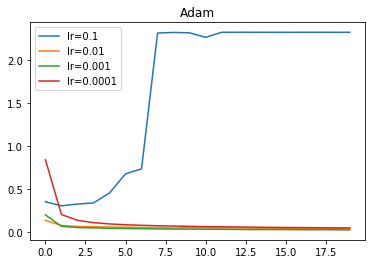

In [240]:
ax = plt.subplot(1,1,1)
ax.plot(adam_loss[0],label="lr=0.1")
ax.plot(adam_loss[1],label="lr=0.01")
ax.plot(adam_loss[2],label="lr=0.001")
ax.plot(adam_loss[3],label="lr=0.0001")
plt.title('Adam')
ax.legend()

### Вывод по Adam: лучше всего сходится при значении lr=1e-3, хорошо работает с меньшими learning rates, чем в SGD и SGD+momentum

###  Построим на одном графики лучших классификаторов для каждого из методов оптимизации

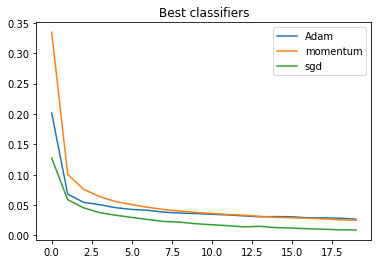

In [242]:
ax = plt.subplot(1,1,1)
ax.plot(adam_loss[2],label="Adam")
ax.plot(mom_loss[0],label="momentum")
ax.plot(sgd_loss[0],label="sgd")
plt.title('Best classifiers')
ax.legend()

# Задача 2

In [245]:
best_lr = 0.1
betas = [0.9, 0.99, 0.5]
mom_loss_beta = []
for beta in betas:
    net = Net(batchnorm=True)
    net = net.cuda() if USE_CUDA else net
    optimizer = SGD(net.parameters(), lr=best_lr, beta=beta)
    loss_curve_sgd_momentum = fit_net(20, net, optimizer)
    mom_loss_beta.append(loss_curve_sgd_momentum)

/nmnt/media/home/farshov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.31327049552058867
Do epoch 1 with loss 0.09551897383016923
Do epoch 2 with loss 0.07118348499813688
Do epoch 3 with loss 0.059762689117623294
Do epoch 4 with loss 0.05380248076358668
Do epoch 5 with loss 0.04847397695618729
Do epoch 6 with loss 0.045528604875130906
Do epoch 7 with loss 0.04246858875665373
Do epoch 8 with loss 0.03962896524783297
Do epoch 9 with loss 0.03750528840609593
Do epoch 10 with loss 0.03572897664831281
Do epoch 11 with loss 0.03367046902154644
Do epoch 12 with loss 0.032415344878506544
Do epoch 13 with loss 0.031329523177521926
Do epoch 14 with loss 0.030336153077299758
Do epoch 15 with loss 0.028159850381338603
Do epoch 16 with loss 0.02718990691309385
Do epoch 17 with loss 0.02621294765519834
Do epoch 18 with loss 0.025101782267748847
Do epoch 19 with loss 0.02450344801480551
Do epoch 0 with loss 1.2874669348152468
Do epoch 1 with loss 0.4808696773180855
Do epoch 2 with loss 0.2981260036381075
Do epoch 3 with loss 0.22998972199635795
Do

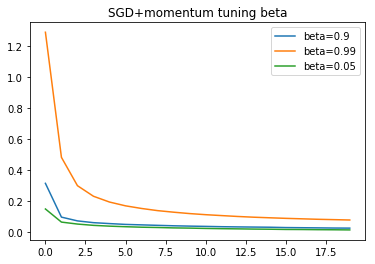

In [246]:
ax = plt.subplot(1,1,1)
ax.plot(mom_loss_beta[0],label="beta=0.9")
ax.plot(mom_loss_beta[1],label="beta=0.99")
ax.plot(mom_loss_beta[2],label="beta=0.05")
plt.title('SGD+momentum tuning beta')
ax.legend()

### Вывод: наилучшие параметры для SGD+momentum: learning_rate = 0.1, beta = 0.05

# Задача 3

In [26]:
import torch
import numpy as np
best_lr = 1e-3
beta = [0.9, 0.99, 0.5]
res = []
i = 0
for beta1 in beta:
    for beta2 in beta:
        print("iter", i, "| beta1:", beta1, "beta2:", beta2)
        i += 1
        net = Net(batchnorm=True)
        net = net.cuda() if USE_CUDA else net
        optimizer = Adam(net.parameters(), lr=best_lr, betas=(beta1, beta2))
        loss_curve_adam = fit_net(20, net, optimizer)
        res.append((loss_curve_adam, beta1, beta2))

iter 0 | beta1: 0.9 beta2: 0.9


/nmnt/media/home/farshov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


iter 1 | beta1: 0.9 beta2: 0.99
iter 2 | beta1: 0.9 beta2: 0.5
iter 3 | beta1: 0.99 beta2: 0.9
iter 4 | beta1: 0.99 beta2: 0.99
iter 5 | beta1: 0.99 beta2: 0.5
iter 6 | beta1: 0.5 beta2: 0.9
iter 7 | beta1: 0.5 beta2: 0.99
iter 8 | beta1: 0.5 beta2: 0.5


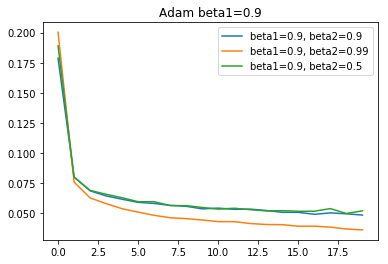

In [29]:
ax = plt.subplot(1,1,1)
for i in range(0, 3):
    ax.plot(res[i][0], label="beta1="+str(res[i][1])+", beta2="+str(res[i][2]))
plt.title('Adam beta1=0.9')
ax.legend()

#### Лучший: beta1=0.9, beta2=0.99

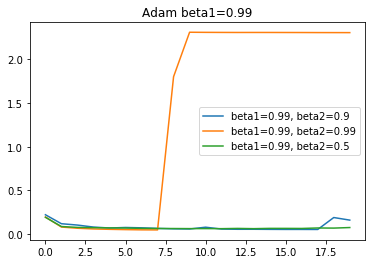

In [31]:
ax = plt.subplot(1,1,1)
for i in range(3, 6):
    ax.plot(res[i][0], label="beta1="+str(res[i][1])+", beta2="+str(res[i][2]))
plt.title('Adam beta1=0.99')
ax.legend()

#### Лучший: beta1=0.99, beta2=0.5

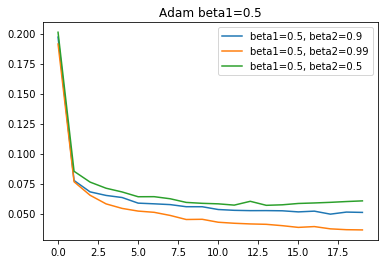

In [33]:
ax = plt.subplot(1,1,1)
for i in range(6, 9):
    ax.plot(res[i][0], label="beta1="+str(res[i][1])+", beta2="+str(res[i][2]))
plt.title('Adam beta1=0.5')
ax.legend()

#### Лучший: beta1=0.5, beta2=0.99

### Построим три лучших адама

(0.02, 0.1)

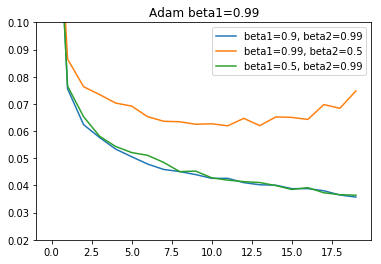

In [37]:
ax = plt.subplot(1,1,1)
ax.plot(res[1][0], label="beta1="+str(res[1][1])+", beta2="+str(res[1][2]))
ax.plot(res[5][0], label="beta1="+str(res[5][1])+", beta2="+str(res[5][2]))
ax.plot(res[7][0], label="beta1="+str(res[7][1])+", beta2="+str(res[7][2]))
plt.title('Adam beta1=0.99')
ax.legend()
plt.ylim(0.02, 0.1)

### Вывод: наилучшие параметры для Adam: 
    1) learning_rate = 1e-3, beta1 = 0.9, beta2 = 0.99 - при данных параметрах сходится стабильней
    2) learning_rate = 1e-3, beta1 = 0.5, beta2 = 0.99